# ML project

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils

plt.rcParams['figure.figsize'] = (17, 5)

## Evaluation function

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

def valuate(clf, x_test, y_test):
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, title='Confusion matrix')


## Dataset and features manipulation

### Load features and metadata 

In [3]:
# Load metadata and features.
tracks = utils.load('./fma_metadata/tracks.csv')
features = utils.load('./fma_metadata/features.csv')

np.testing.assert_array_equal(features.index, tracks.index)

tracks.shape, features.shape

((106574, 52), (106574, 518))

In [7]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
# columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
# columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


### Dataset selection and train-test splitting

In [63]:
medium = tracks['set', 'subset'] <= 'medium'

train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[medium & train, ('track', 'genre_top')]
y_test = tracks.loc[medium & test, ('track', 'genre_top')]

X_train = features.loc[medium & train]
X_test = features.loc[medium & test]

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

19922 training examples, 2573 testing examples
518 features, 16 classes


In [64]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[-2.31296916e-01, -2.33975905e-01,  1.16533023e-01, ...,
        -5.13189614e-01, -8.52162570e-01, -9.01382593e-02],
       [ 9.26064840e-02,  6.82777280e-01, -1.35499410e-01, ...,
        -1.21313133e-01, -7.00878309e-01, -8.42291385e-01],
       [-4.66735180e-01, -2.94790500e-01,  2.05082936e-03, ...,
        -5.13189614e-01,  8.43091404e-01, -2.73593365e-02],
       ...,
       [-4.89343929e-01, -4.94986994e-01, -1.99236596e-01, ...,
        -3.17251373e-01,  1.72207604e-01,  2.64103395e+00],
       [-5.39302574e-01, -5.88055804e-01, -1.77953967e-01, ...,
        -1.21313133e-01,  1.36941072e+00,  1.76063047e+00],
       [-4.79443152e-01, -4.57697694e-01, -8.36406594e-02, ...,
         1.25025455e+00,  1.07589628e-01,  3.55625521e+00]])

## Models

### SVM Classifier

In [36]:
# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 42.29%


                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00         8
          Classical       0.56      0.40      0.47        62
            Country       0.00      0.00      0.00        18
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.39      0.71      0.51       632
       Experimental       0.39      0.05      0.09       225
               Folk       0.30      0.24      0.27       152
            Hip-Hop       0.50      0.00      0.01       220
       Instrumental       0.39      0.09      0.14       174
      International       0.00      0.00      0.00       102
               Jazz       0.00      0.00      0.00        39
Old-Time / Historic       0.75      0.06      0.11        51
                Pop       0.00      0.00      0.00       119
               Rock       0.46      0.77      0.58       711
           Soul-RnB       0.00      0.00      0.00        42
             Spoken    

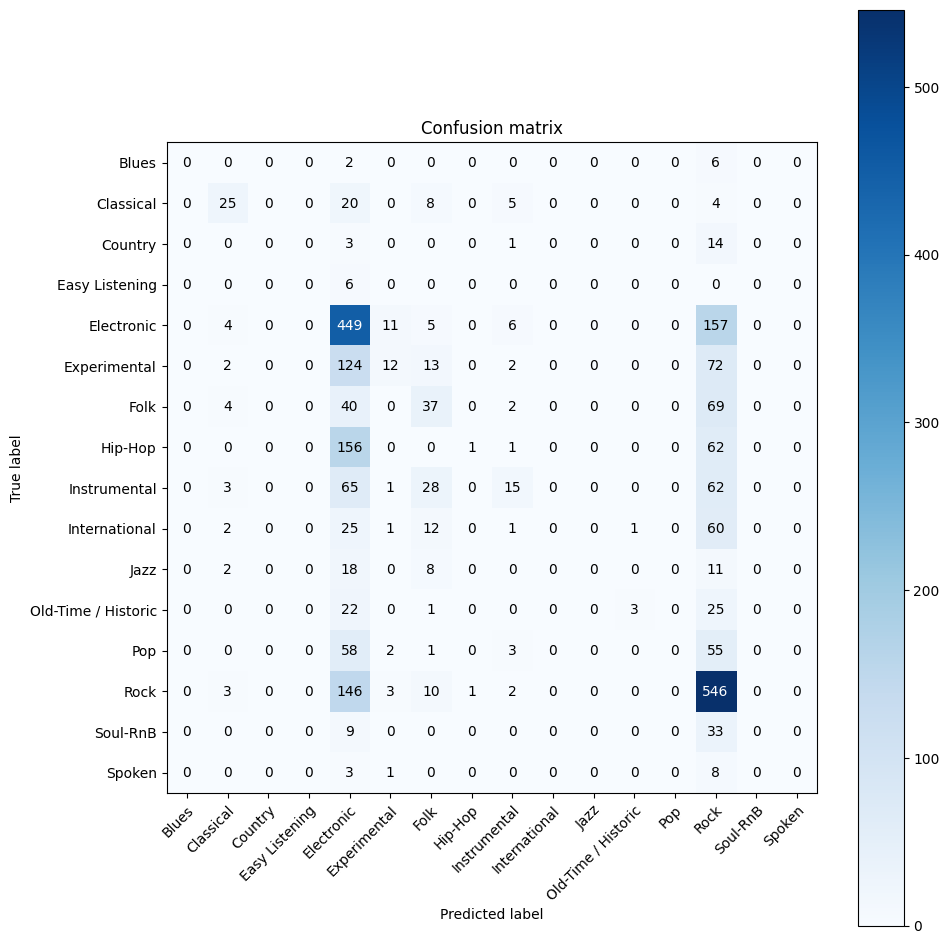

In [37]:
valuate(clf, X_test, y_test)

### DecTree, Bagging, Boosting

In [26]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, BaggingClassifier)
from six.moves import xrange
from sklearn import tree
from sklearn.base import clone
from sklearn.model_selection import cross_val_score

In [27]:
maxdepth=8
clf = tree.DecisionTreeClassifier(max_depth=maxdepth)

clf = clf.fit(X_train, y_train)

scores_train = clf.score(X_train, y_train)
scores_test = clf.score(X_test, y_test)

print('Accuracy: {:.2%}'.format(scores_test))


Accuracy: 34.40%


                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00         8
          Classical       0.16      0.21      0.18        62
            Country       0.00      0.00      0.00        18
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.34      0.55      0.42       632
       Experimental       0.18      0.03      0.05       225
               Folk       0.11      0.07      0.09       152
            Hip-Hop       0.25      0.03      0.05       220
       Instrumental       0.16      0.03      0.06       174
      International       0.00      0.00      0.00       102
               Jazz       0.00      0.00      0.00        39
Old-Time / Historic       0.00      0.00      0.00        51
                Pop       0.00      0.00      0.00       119
               Rock       0.39      0.70      0.50       711
           Soul-RnB       0.00      0.00      0.00        42
             Spoken    

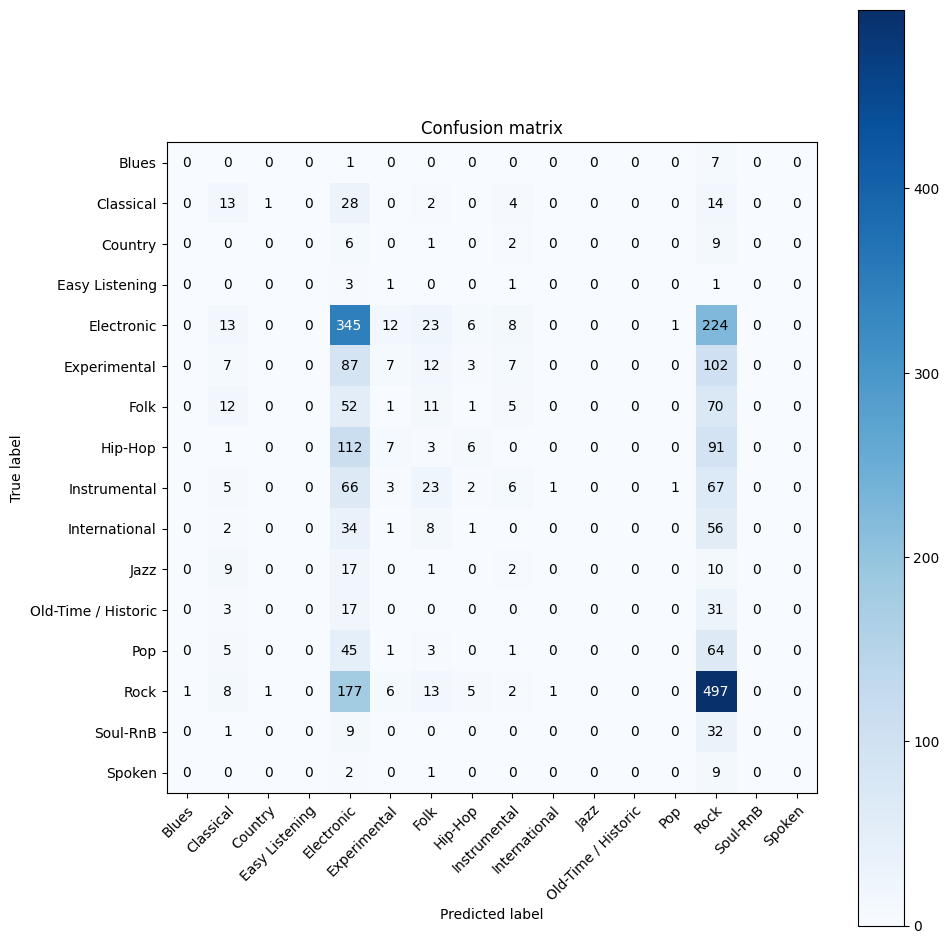

In [28]:
valuate(clf, X_test, y_test)

In [29]:
n_estimators = 8
md = 1
classifier = tree.DecisionTreeClassifier(max_depth=md)

clf = BaggingClassifier(classifier,n_estimators=n_estimators)

clf = clf.fit(X_train, y_train)

scores_train = clf.score(X_train, y_train)
scores_test = clf.score(X_test, y_test)

print('Accuracy: {:.2%}'.format(scores_test))

Accuracy: 31.25%


In [60]:
n_estimators = 100
clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=3)


clf = clf.fit(X_train, y_train)

scores_train = clf.score(X_train, y_train)
scores_test = clf.score(X_test, y_test)

print('Accuracy: {:.2%}'.format(scores_test))

Accuracy: 47.30%


In [44]:
n_estimators = 8
md = 2
classifier = tree.DecisionTreeClassifier(max_depth=md)
clf = AdaBoostClassifier(classifier,n_estimators=n_estimators)

clf = clf.fit(X_train, y_train)

scores_train = clf.score(X_train, y_train)
scores_test = clf.score(X_test, y_test)

print('Accuracy: {:.2%}'.format(scores_test))

Accuracy: 40.65%


In [11]:
scores = []
md = 2
r = range(1,30)
for k in r:
    score = cross_val_score(estimator=AdaBoostClassifier(DecisionTreeClassifier(max_depth=md),n_estimators=k, algorithm='SAMME'), X=X_train, y=y_train, cv=10, scoring='accuracy')
    scores.append(score.mean())


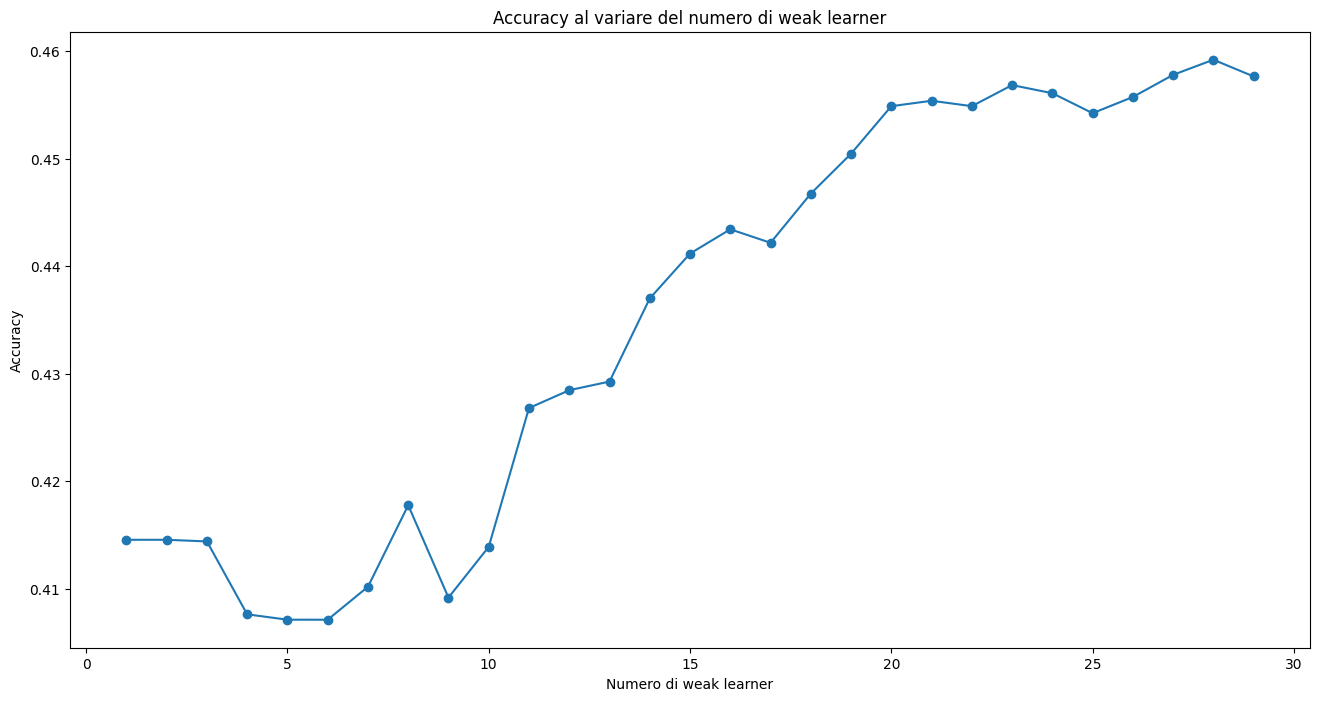

In [12]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot(r, scores, marker='o') 
plt.xlabel(r'Numero di weak learner')
plt.ylabel('Accuracy')
plt.title(r'Accuracy al variare del numero di weak learner')
plt.show()


### Multilayer Perceptron

In [38]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [39]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(y):
    y = y.values.reshape(-1, 1)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    return y


In [46]:
from torch import nn

class MultiClassNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(84, 84)
        self.act = nn.ReLU()
        self.output = nn.Linear(84, 16)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

In [47]:
X_train.values

array([[ 0.81208758,  0.37492265, -0.17016381, ..., -0.75645731,
        -0.8800006 ,  0.15784258],
       [-0.69270915, -0.56574915, -0.24142847, ...,  0.34028955,
         1.0931668 ,  0.7427662 ],
       [ 0.50909586,  1.49239557, -0.18284776, ..., -0.223146  ,
        -0.39319222, -0.06926588],
       ...,
       [-0.21797951, -0.21284068, -0.17976399, ..., -1.32794371,
        -0.92196135, -1.21955471],
       [-0.04243109,  0.11747367, -0.03157417, ..., -1.34867134,
        -1.43161923, -1.52027078],
       [-0.88126812,  0.38023548,  0.56678116, ...,  1.02097007,
        -0.18750783,  1.01387103]])

In [48]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(one_hot_encoding(y_train), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(one_hot_encoding(y_test), dtype=torch.float32)

In [49]:
y_train_tensor.shape

torch.Size([19922, 16])

In [50]:
y_train.shape

(19922,)

In [51]:
import copy
import tqdm
from torch import optim

model = MultiClassNN()

# loss metric and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 8
batch_size = 200
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )

    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test_tensor)
    ce = loss_fn(y_pred, y_test_tensor)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test_tensor, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)


Epoch 0: 100%|████████████████████| 99/99 [00:00<00:00, 325.21batch/s, acc=0.45, loss=1.88]


Epoch 0 validation: Cross-entropy=2.03, Accuracy=36.0%


Epoch 1: 100%|████████████████████| 99/99 [00:00<00:00, 367.51batch/s, acc=0.47, loss=1.78]


Epoch 1 validation: Cross-entropy=1.96, Accuracy=36.9%


Epoch 2: 100%|████████████████████| 99/99 [00:00<00:00, 405.91batch/s, acc=0.47, loss=1.71]


Epoch 2 validation: Cross-entropy=1.92, Accuracy=38.6%


Epoch 3: 100%|███████████████████| 99/99 [00:00<00:00, 392.19batch/s, acc=0.495, loss=1.66]


Epoch 3 validation: Cross-entropy=1.88, Accuracy=39.5%


Epoch 4: 100%|████████████████████| 99/99 [00:00<00:00, 366.78batch/s, acc=0.52, loss=1.63]


Epoch 4 validation: Cross-entropy=1.86, Accuracy=40.1%


Epoch 5: 100%|█████████████████████| 99/99 [00:00<00:00, 366.30batch/s, acc=0.52, loss=1.6]


Epoch 5 validation: Cross-entropy=1.85, Accuracy=40.9%


Epoch 6: 100%|███████████████████| 99/99 [00:00<00:00, 378.32batch/s, acc=0.525, loss=1.58]


Epoch 6 validation: Cross-entropy=1.84, Accuracy=41.1%


Epoch 7: 100%|████████████████████| 99/99 [00:00<00:00, 392.76batch/s, acc=0.53, loss=1.56]


Epoch 7 validation: Cross-entropy=1.83, Accuracy=41.2%


<All keys matched successfully>

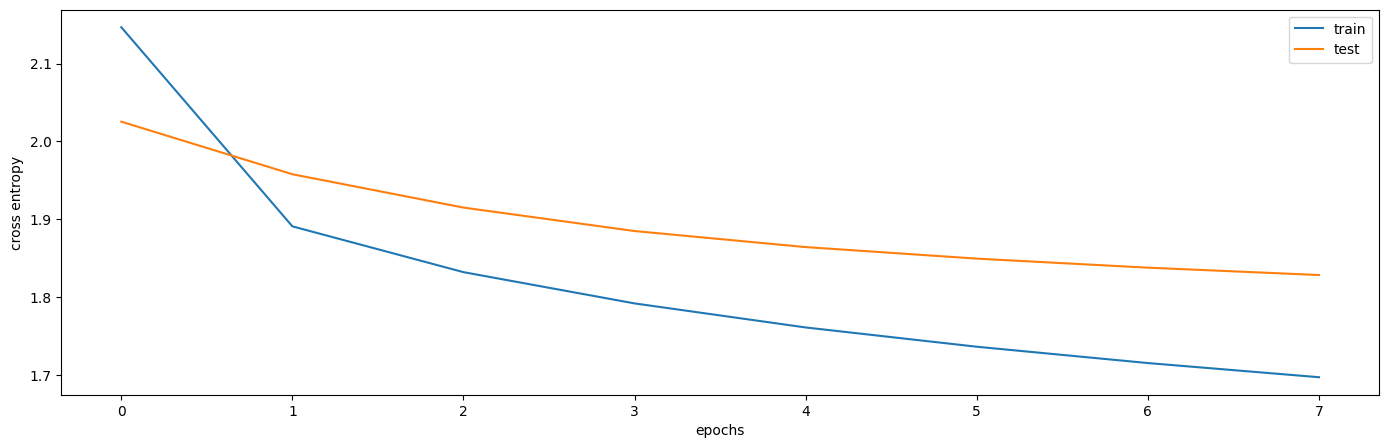

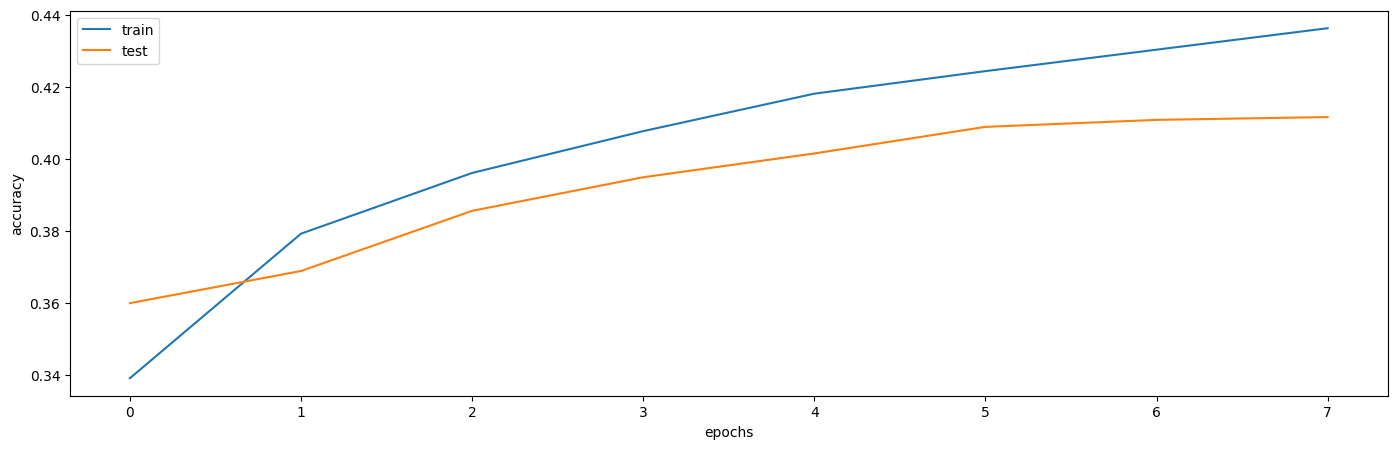

In [52]:
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [61]:
torch.argmax(y_pred, 1) == torch.argmax(y_test_tensor, 1)

tensor([ True,  True, False,  ...,  True, False, False])

### Softmax regression

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [58]:
scaler = StandardScaler()
logreg = LogisticRegression()

lr_model = LogisticRegression(max_iter=200, solver='lbfgs', multi_class='multinomial')

model = lr_model.fit(X_train, y_train)


In [59]:
y_t = model.predict(X_test)

                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00         8
          Classical       0.45      0.48      0.47        62
            Country       0.00      0.00      0.00        18
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.39      0.59      0.47       632
       Experimental       0.29      0.06      0.10       225
               Folk       0.21      0.13      0.16       152
            Hip-Hop       0.28      0.02      0.04       220
       Instrumental       0.19      0.03      0.06       174
      International       0.00      0.00      0.00       102
               Jazz       0.00      0.00      0.00        39
Old-Time / Historic       0.30      0.16      0.21        51
                Pop       0.00      0.00      0.00       119
               Rock       0.42      0.78      0.55       711
           Soul-RnB       0.00      0.00      0.00        42
             Spoken    

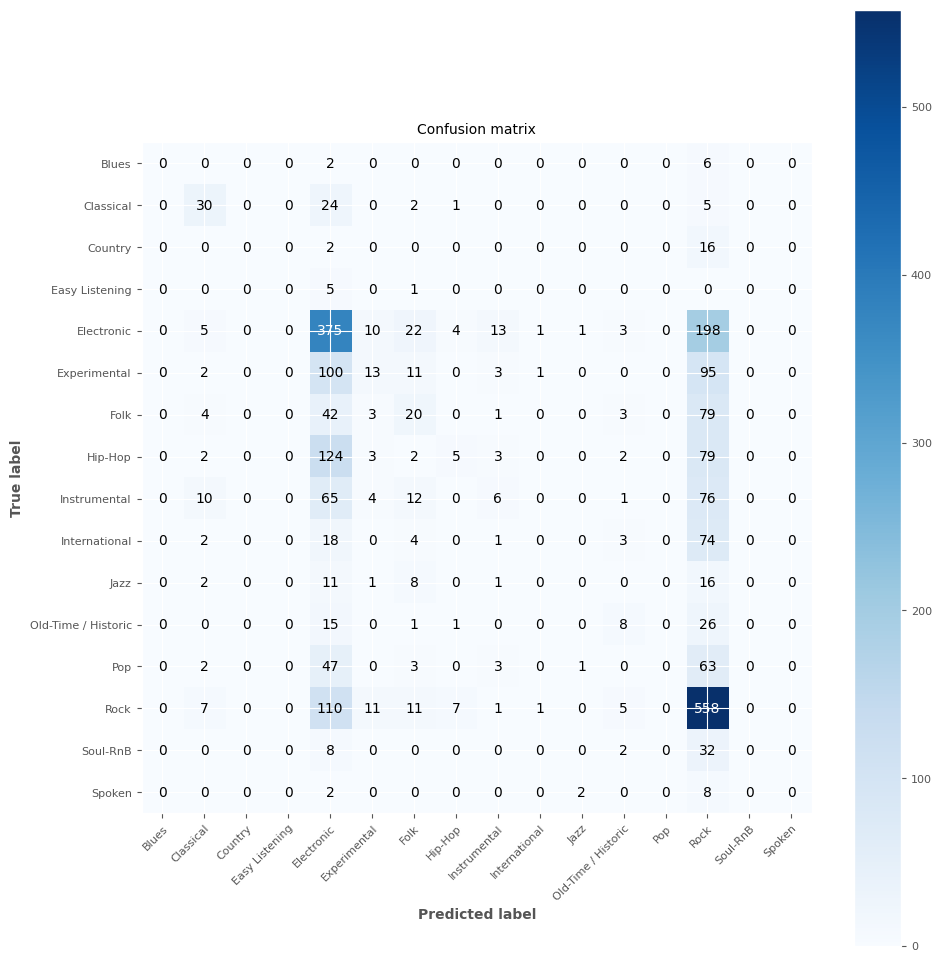

In [60]:
valuate(model, X_test, y_test)

In [67]:
print(accuracy_score(y_t,y_test))

0.6008550330353672


### Gaussian discriminant classifier

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_classifier = LinearDiscriminantAnalysis().fit(X_train, y_train)

                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00         8
          Classical       0.41      0.24      0.30        62
            Country       0.00      0.00      0.00        18
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.39      0.56      0.46       632
       Experimental       0.22      0.07      0.10       225
               Folk       0.19      0.17      0.18       152
            Hip-Hop       0.15      0.01      0.02       220
       Instrumental       0.18      0.07      0.10       174
      International       0.00      0.00      0.00       102
               Jazz       0.50      0.03      0.05        39
Old-Time / Historic       0.33      0.02      0.04        51
                Pop       0.00      0.00      0.00       119
               Rock       0.42      0.78      0.55       711
           Soul-RnB       0.00      0.00      0.00        42
             Spoken    

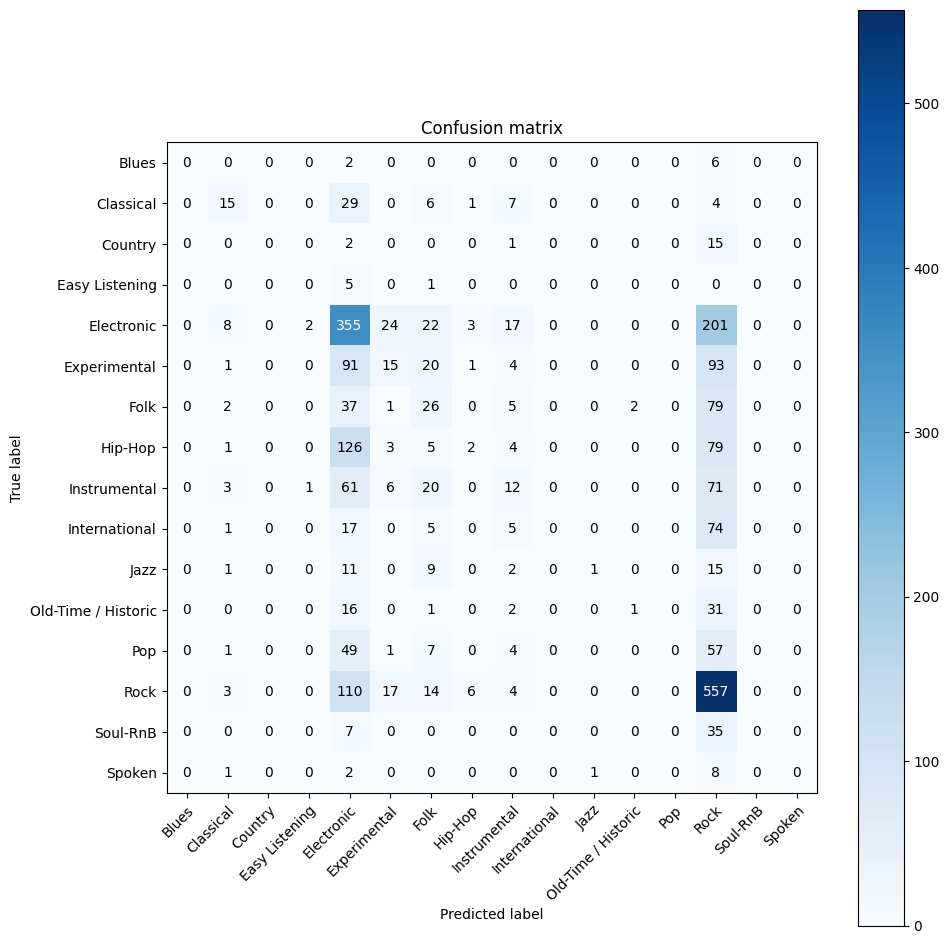

In [54]:
valuate(lda_classifier, X_test, y_test)

### kNN classifier

In [55]:
from sklearn.neighbors import KNeighborsClassifier as KNN

ks = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
train_errs = []
test_errs = []
for k in ks:
    knn = KNN(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_errs.append(knn.score(X_train, y_train))
    test_errs.append(knn.score(X_test, y_test))

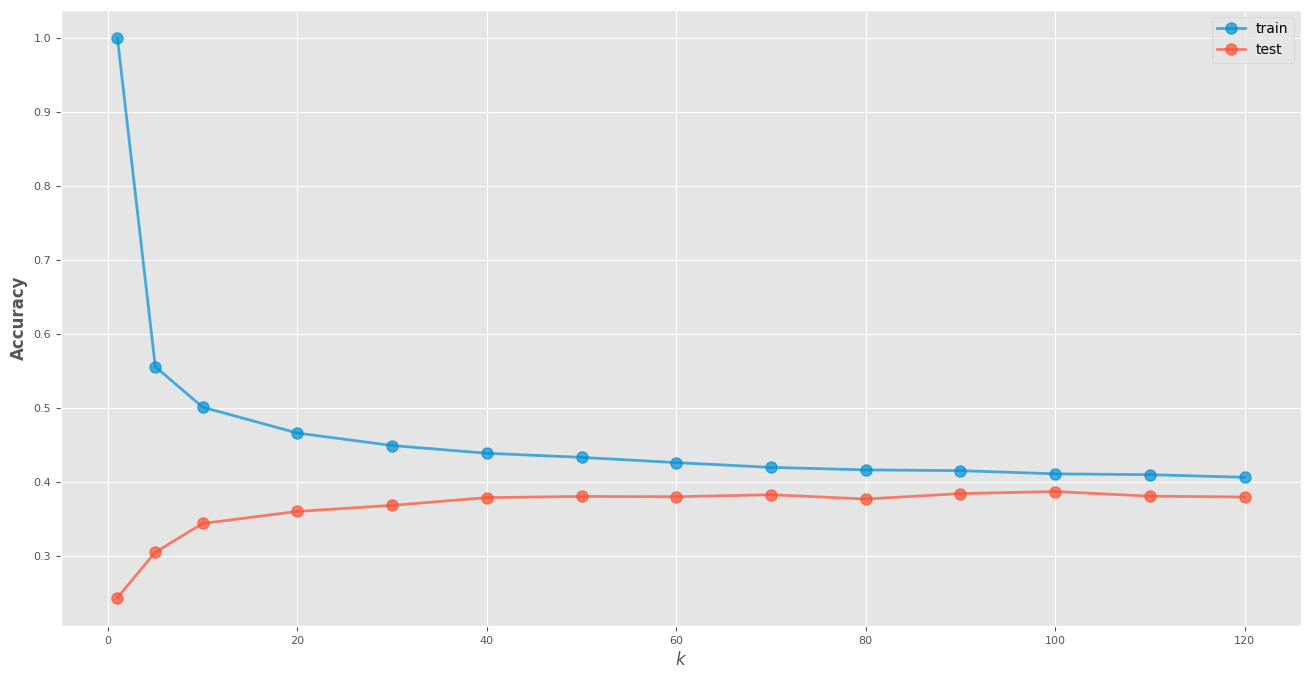

In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])


fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.tick_params(axis='both', which='major', labelsize=8)
ax.plot(ks, train_errs, '-o', color=colors[0], markersize=8, alpha=.7, label='train')
ax.plot(ks, test_errs, '-o', color=colors[1], markersize=8, alpha=.7, label='test')
plt.legend(fontsize=10)
plt.xlabel('$k$', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.show()

## PCA

In [81]:
from sklearn.decomposition import PCA

n_components = 50

print(f"Extracting the top {n_components} eigenfaces from { X_train.shape[0]} songs")
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
pca.explained_variance_

Extracting the top 50 eigenfaces from 19922 songs


array([61.58763775, 38.80527346, 22.44913202, 15.93993898, 14.18244621,
       13.09442412, 12.86674573, 12.59181282, 11.44315257,  9.81596224,
        9.58783373,  8.28165848,  7.77070342,  7.34431285,  7.02604678,
        6.78454252,  5.73686688,  5.38842324,  5.17602018,  5.07233807,
        4.86121429,  4.56227266,  4.32190446,  4.21503061,  4.04177359,
        3.77221237,  3.72988974,  3.6495819 ,  3.50258234,  3.34794693,
        3.25231058,  2.93723309,  2.76106184,  2.70809541,  2.66805179,
        2.55500486,  2.5048966 ,  2.40943534,  2.34379452,  2.28737107,
        2.2160521 ,  2.18532937,  2.0727709 ,  2.03231343,  1.95303409,
        1.94083213,  1.89016472,  1.8756296 ,  1.80786349,  1.76528195])

In [82]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [83]:
print(X_train_pca)

[[ 0.38277198 -1.42439639 -0.01243543 ... -0.22637979 -0.10998264
  -0.98938841]
 [ 1.57038094 -0.3783836   0.50650623 ...  0.4589969   0.90480225
   0.69252496]
 [ 0.01058271  1.63234119 -0.10272057 ...  0.59323805  0.48558376
   1.94660929]
 ...
 [-1.71291037 -0.63426118  0.01943458 ... -0.40044444  0.49984548
  -0.33351458]
 [-1.5228479  -1.48702404  1.13810848 ...  0.49997714  0.5957525
  -1.18738946]
 [-1.0017608  -0.77308828 -0.31732165 ...  0.63068082  0.12188461
   0.06879556]]


In [84]:
# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train_pca, y_train)


SVC()

                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00         8
          Classical       0.43      0.29      0.35        62
            Country       0.00      0.00      0.00        18
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.55      0.82      0.66       632
       Experimental       0.41      0.26      0.32       225
               Folk       0.28      0.33      0.30       152
            Hip-Hop       0.61      0.42      0.50       220
       Instrumental       0.39      0.18      0.25       174
      International       0.45      0.13      0.20       102
               Jazz       0.92      0.28      0.43        39
Old-Time / Historic       0.85      0.98      0.91        51
                Pop       0.40      0.02      0.03       119
               Rock       0.65      0.86      0.74       711
           Soul-RnB       0.00      0.00      0.00        42
             Spoken    

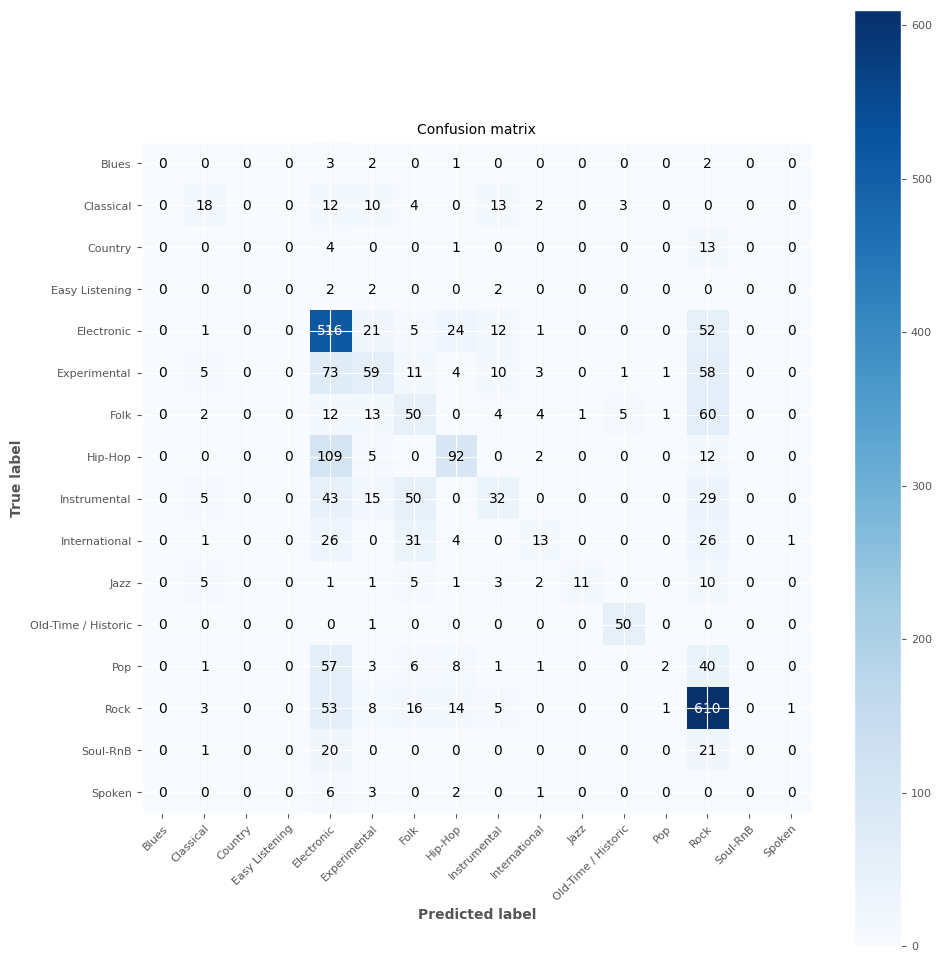

In [76]:
valuate(clf, X_test_pca, y_test)

In [87]:
col_names = [name+"_"+stat+"_"+parameter for (name, stat, parameter) in X_train.columns]

important_features = np.abs(pca.components_[0])  # Prendi il valore assoluto della prima componente
feature_importance = list(zip(col_names, pca.explained_variance_ratio_))
feature_importance.sort(key=lambda x: x[1], reverse=True)  # Ordina per importanza
pca_feature_importance = feature_importance[:80]


print("Varianza spiegata da ciascuna componente:", pca_feature_importance)
print("Varianza totale spiegata:", np.sum(pca.explained_variance_ratio_))

Varianza spiegata da ciascuna componente: [('chroma_cens_kurtosis_01', np.float64(0.11888908554219471)), ('chroma_cens_kurtosis_02', np.float64(0.07490989497510536)), ('chroma_cens_kurtosis_03', np.float64(0.04333591730513032)), ('chroma_cens_kurtosis_04', np.float64(0.030770538337471315)), ('chroma_cens_kurtosis_05', np.float64(0.02737786546386591)), ('chroma_cens_kurtosis_06', np.float64(0.02527754216046656)), ('chroma_cens_kurtosis_07', np.float64(0.024838030645148956)), ('chroma_cens_kurtosis_08', np.float64(0.024307298776604886)), ('chroma_cens_kurtosis_09', np.float64(0.022089919251167312)), ('chroma_cens_kurtosis_10', np.float64(0.018948782858152692)), ('chroma_cens_kurtosis_11', np.float64(0.01850840243569849)), ('chroma_cens_kurtosis_12', np.float64(0.015986955173491562)), ('chroma_cens_max_01', np.float64(0.015000604942574049)), ('chroma_cens_max_02', np.float64(0.014177498448501849)), ('chroma_cens_max_03', np.float64(0.013563116034884403)), ('chroma_cens_max_04', np.float64

In [79]:
ipd.display(X_train_pca)

array([[ 0.38277198, -1.42439639, -0.01243528, ..., -0.02822025,
         1.60885164,  0.85708583],
       [ 1.57038094, -0.3783836 ,  0.50650642, ...,  0.29618856,
        -0.24277098, -0.46881145],
       [ 0.01058271,  1.63234119, -0.10272075, ..., -1.11578605,
        -0.17554173,  0.55159459],
       ...,
       [-1.71291037, -0.63426118,  0.01943457, ...,  0.10039197,
        -0.33070372,  0.24397851],
       [-1.5228479 , -1.48702404,  1.13810848, ...,  1.17321777,
        -0.15510381, -0.03065039],
       [-1.0017608 , -0.77308828, -0.31732167, ...,  0.67482082,
        -0.57195852, -0.05760511]])